**Controller Example**

In [1]:
import sympy as sp
from sympy import sin, cos, Matrix, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d  
from scipy.optimize import minimize

In [2]:
def reference_trajectory(t):
    return -np.pi/2 - np.deg2rad(20) * np.cos(1*t)

In [3]:
# Pendulum
g = 9.81 # m/s^2 
L = 1.0 * 0.4 # m
m = 80 * 0.2 # kg

def pendulum(t, y, M):
    omega, q = y
    domega = - (g/L) * np.cos(q) + M / (m*L**2)
    dq = omega
    return [domega, dq]

In [4]:
# # Sensor
# U_0 = 3 # V
# R_pot = 6e4 # Ohm
# R3 = 3e4 # Ohm
# R4 = 1e4 # Ohm
# alpha_max = np.deg2rad(270) # rad
# U_ADC = 3 # V
# n_bits_ADC = 8 # bits

# def sensor(q, noise_std=0):
#     is_scalar = np.isscalar(q)
#     q = np.atleast_1d(q)

#     alpha = q + np.pi/2
#     U_a = U_0 * (3/4 - alpha/alpha_max)

#     # Add Gaussian Noise
#     mean = 0
#     noise = np.random.normal(mean, noise_std, size=U_a.shape)

#     # Overlay signal with noise
#     U_a_noisy = np.array(U_a + noise)

#     U_a_noisy[U_a_noisy < 0] = 0
#     U_a_noisy[U_a_noisy > U_ADC] = U_ADC

#     # Convert to digital value
#     Q = 2**n_bits_ADC - 1
#     delta = U_ADC / Q
#     U_a_digital = delta * np.round(U_a_noisy / delta)
#     # U_a_digital = np.round(U_a_noisy / delta)

#     if is_scalar:
#         return U_a_digital[0]
    
#     return U_a_digital

In [5]:
# # Drive
# U_M = 16 # V - motor voltage
# U_rated = 48 # V - rated voltage
# R = 0.151 # Ohm - resistance
# L = 121e-6 # H - inductance
# n_0 = 12916 # rpm - no load speed
# w_0 = 2 * np.pi * n_0 / 60 # rad/s
# k_n = n_0 * 2 * np.pi / (60 * U_rated) # rad/(V*s) - speed constant
# k_M = 0.03 # Nm/A - torque constant
# i_G = 60 # gear ratio
# eta_G = 0.85 # gear efficiency

# def drive(t, M, u_control, omega_m):
#     U = U_M * u_control

#     I = M / (eta_G * i_G * k_M)
    
#     dI_dt = (1/L) * (U - R*I - omega_m / k_n)

#     dM = eta_G * i_G * k_M * dI_dt
    
#     return [dM]

In [6]:
def system_equations(t, y, args):
    dydt_pendulum = pendulum(t, y, args)
    return dydt_pendulum

In [7]:
# Class PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, T):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.T = T
        self.e_km1 = 0
        self.e_km2 = 0
        self.u_km1 = 0
        pass

    def compute_control(self, reference, state):
        e_k = reference - state
        
        a0 = self.Kp + self.Kd / self.T
        a1 = (self.Ki * self.T - 2 * self.Kd / self.T - self.Kp)
        a2 = self.Kd / self.T

        u_k = self.u_km1 + a0 * e_k + a1 * self.e_km1 + a2 * self.e_km2

        self.u_km1 = u_k
        self.e_km2 = self.e_km1
        self.e_km1 = e_k

        return u_k

In [8]:
q_0 = reference_trajectory(0)
omega_0 = 0

dt_control = 0.1
dt_sim = 0.01

initial_state = [omega_0, q_0]

t_start = 0
t_end = 5

t_control = np.arange(t_start, t_end, dt_control)

num_steps = len(t_control)


In [9]:
def simulation(params):
    Kp, Ki, Kd = params
    controller = PIDController(Kp, Ki, Kd, dt_control)
    
    t_total = []
    y_total = []
    torque_array = []
    ref_array = []

    current_state = initial_state

    for i in range(num_steps):
        t = t_control[i]

        # Desired trajectory
        ref = reference_trajectory(t)

        torque = controller.compute_control(ref, current_state[1])

        t_span = [t, min(t + dt_control, t_end)]
        t_eval = np.linspace(t_span[0], t_span[1], int((t_span[1] - t_span[0]) / dt_sim) + 1)

        sol = solve_ivp(system_equations, t_span, current_state, args=(torque,), t_eval=t_eval, dense_output=True, method='RK45')
        
        current_state = sol.y[:, -1]

        if (len(t_total) == 0):
            t_total.extend(sol.t)
            y_total.extend(sol.y.T)
            torque_array.extend([torque] * len(sol.t))
            ref_array.extend([ref] * len(sol.t))

        else:
            t_total.extend(sol.t[1:])
            y_total.extend(sol.y[:, 1:].T)
            torque_array.extend([torque] * (len(sol.t)-1))
            ref_array.extend([ref] * (len(sol.t)-1))

        
    return t_total, y_total, ref_array, torque_array


In [10]:
# Objective function for optimization
def cost_function(params):
    t_sol, y_sol, ref_sol, torque_sol = simulation(params)

    total_error = np.sum(np.abs(np.array(y_sol)[:, 1] - np.array(ref_sol))**2)
    total_u_control = np.sum(np.abs(np.array(torque_sol))**2)

    return total_error + 0*total_u_control

In [11]:
# Initial values for the PID parameters Kp, Ki, Kd
Kp = 99
Ki = 500
Kd = 30

initial_params = [Kp, Ki, Kd]

# bounds for the PID parameters
bounds = [(0, 500), (0, 500), (0, 500)]

total_error = 0
total_u_control = 0

# Run the optimization
result = minimize(cost_function, initial_params, bounds=bounds, method='L-BFGS-B')

# Optimized PID parameters
Kp, Ki, Kd = result.x
print("Optimized PID parameters: ", Kp, Ki, Kd)

t_sol, y_sol, ref_sol, torque_sol = simulation([Kp, Ki, Kd])

# Optimized PID parameters:  4.3834111356883826e-08 500.0 29.000000041291734

Optimized PID parameters:  97.11066192572329 500.0 30.04981304923553


In [12]:
sol_omega = [y[0] for y in y_sol]
sol_q = [y[1] for y in y_sol]
#sol_M = [y[2] for y in y_sol]

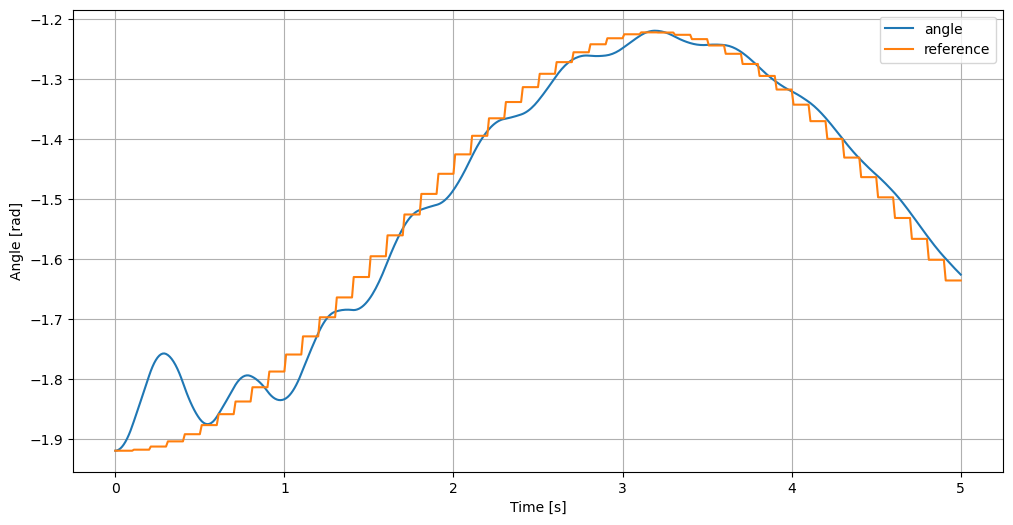

In [13]:
# plot oendulum angle and reference angle
plt.figure(figsize=(12, 6))
plt.plot(t_sol, sol_q, label='angle')
plt.plot(t_sol, ref_sol, label='reference')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid()
plt.show()

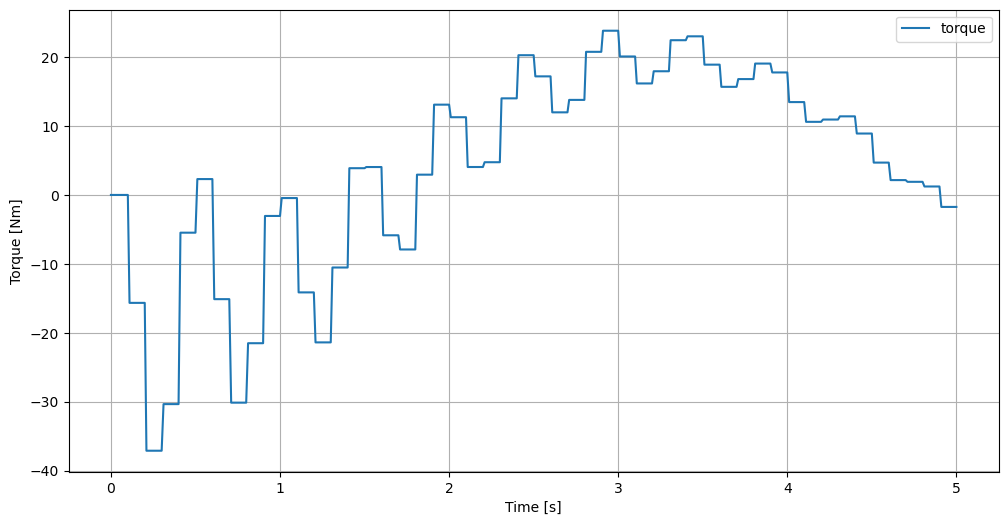

In [14]:
#plot the torque
plt.figure(figsize=(12, 6))
plt.plot(t_sol, torque_sol, label='torque')
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid()
plt.show()
